# Actividad 3 – *Machine Learning II*

**Estudiante(s):** *(Paula Álvarez- Marcelo Carmona)*  




In [17]:
# Librerías y configuración

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    ConfusionMatrixDisplay, roc_auc_score, average_precision_score,
    roc_curve, auc, precision_recall_curve
)
from scipy.stats.contingency import association  # Cramér's V
from sklearn.linear_model import LinearRegression
import time

plt.style.use('seaborn-v0_8')
np.set_printoptions(suppress=True)
RANDOM_STATE = 42


In [18]:
#Montar google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
ruta_driver = "/content/drive/MyDrive/Data Science/Machine Learning II/Actividad III"
df = pd.read_csv(ruta_driver + "/data-churn.csv")

# Tamaño del dataset
print(f"Dimensiones del dataset: {df.shape}")

Dimensiones del dataset: (7043, 21)


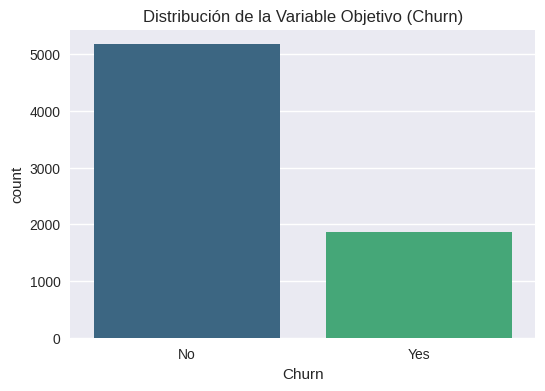

Proporción de Churn:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

Estadísticos de variables numéricas:


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


Variables numéricas: ['SeniorCitizen', 'tenure', 'MonthlyCharges']
Variables categóricas: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']


In [20]:
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df, palette='viridis', hue='Churn', legend=False)
plt.title('Distribución de la Variable Objetivo (Churn)')
plt.show()

print("Proporción de Churn:")
print(df['Churn'].value_counts(normalize=True))

# Estadísticos básicos
print("\nEstadísticos de variables numéricas:")
display(df.describe())

variables_numericas = df.select_dtypes(include=['number']).columns.tolist()
print(f"Variables numéricas: {variables_numericas}")

variables_categoricas = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Variables categóricas: {variables_categoricas}")

In [21]:

# Carga de datos y tipificación

TARGET_CANDIDATES = ["Churn","churn","CHURN","Exited","Customer_Churn"]
target = next((c for c in TARGET_CANDIDATES if c in df.columns), None)
if target is None:
    raise ValueError(f"No se encontró columna objetivo. Columnas: {list(df.columns)}")

# Separación X/y
X = df.drop(columns=[target])
y = df[target]

# Convertir columnas 'numéricas en texto' a float si procede
for c in X.select_dtypes(include=['object','string']).columns:
    s = X[c].dropna().astype(str).str.replace(',', '.', regex=False)
    if len(s) and pd.to_numeric(s, errors='coerce').notna().mean() > 0.9:
        X[c] = pd.to_numeric(X[c].astype(str).str.replace(',', '.', regex=False), errors='coerce')

num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(exclude='number').columns.tolist()

# y binaria: mapear yes/no/true/false -> 0/1; si no aplica, factorizar
if y.dtype == 'object' or str(y.dtype).startswith('string'):
    y_map = y.astype(str).str.strip().str.lower().map({'yes':1,'true':1,'1':1,'no':0,'false':0,'0':0})
    if y_map.isna().any():
        y = pd.Categorical(y).codes
    else:
        y = y_map.astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(f"Registros: {df.shape[0]} | Features: {X.shape[1]} | Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)}")


Registros: 7043 | Features: 20 | Numéricas: 4 | Categóricas: 16


In [22]:

# Preprocesamiento base: imputación + escalado + one-hot
# - Numéricas: mediana + StandardScaler
# - Categóricas: moda + OneHotEncoder (sparse=False para compatibilidad)

try:
    ohe_dense = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe_dense = OneHotEncoder(handle_unknown='ignore', sparse=False)

preproc_dense = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imp', SimpleImputer(strategy='median')),
                          ('sc', StandardScaler())]), num_cols),
        ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                          ('ohe', ohe_dense)]), cat_cols),
    ],
    remainder='drop'
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


## Paso 1. Naïve Bayes
**Selección de variante**: se entrenan **GaussianNB** (matriz densa con numéricas escaladas y *one‑hot*) y **BernoulliNB** (matriz binaria si se discretizan numéricas).  
**Hiperparámetros**: `var_smoothing` (GaussianNB); `alpha`, `fit_prior`, `binarize` (BernoulliNB).  
**GridSearchCV** con evaluación multi‑métrica y `refit='f1_macro'`.


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Tiempo NB (grid total): 97.86 s
=== Mejor GaussianNB === {'clf__var_smoothing': np.float64(1e-12)} | CV F1 macro: 0.2097
=== Mejor BernoulliNB === {'clf__alpha': 2.0, 'clf__fit_prior': False} | CV F1 macro: 0.7316

>>> NB seleccionado: BernoulliNB

===== TEST REPORT [BernoulliNB] =====
Accuracy:           0.7743
Precision (macro):  0.7134
Recall (macro):     0.7251
F1 (macro):         0.7186
AUC-ROC (macro OvR):0.8115
PR-AUC  (macro):    0.7529

Classification report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84      1035
           1       0.57      0.62      0.59       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.77      0.78      1409



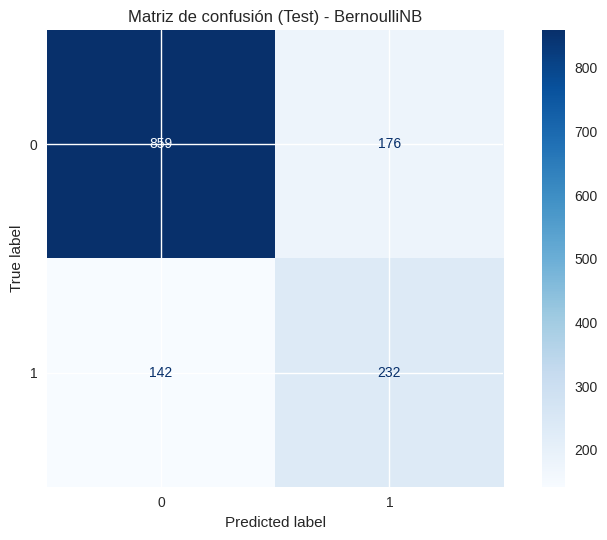

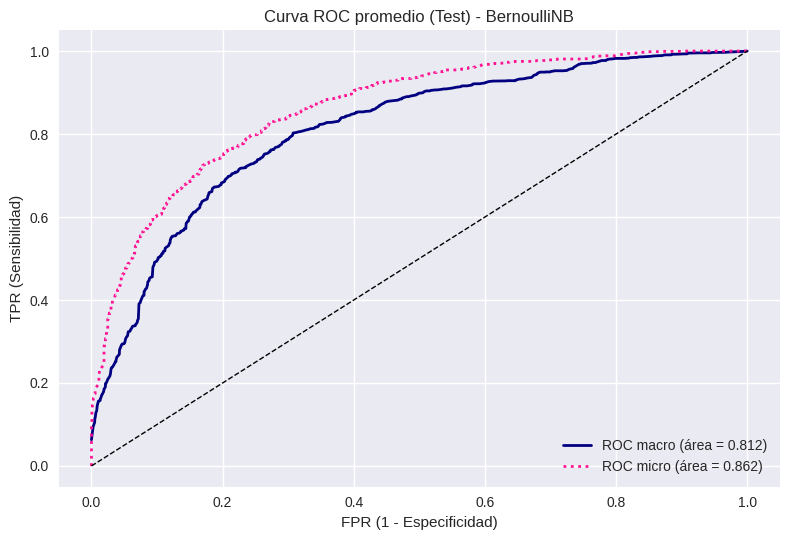

/tmp/ipython-input-3082439953.py:146: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(all_rec, mean_prec, label=f"PR macro (área \u2248 {np.trapz(mean_prec, all_rec):.3f})", color='darkgreen', lw=2)


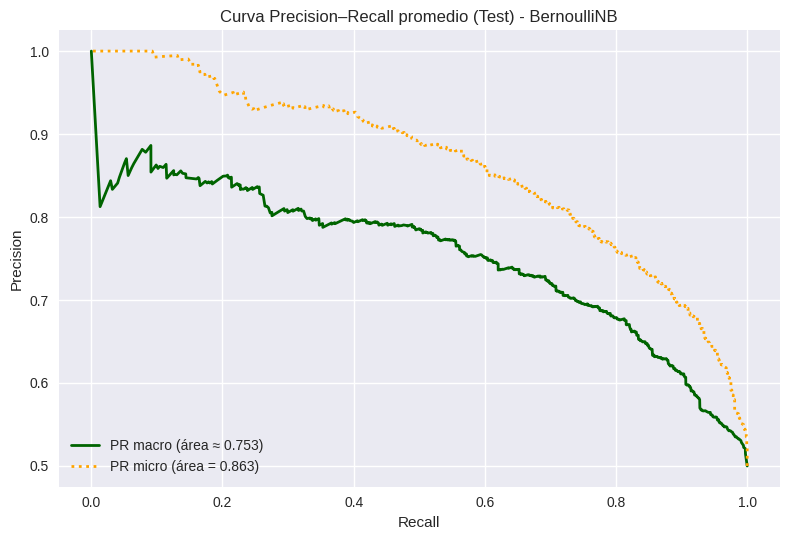

In [23]:

# %% 1. Naïve Bayes: GaussianNB y BernoulliNB (con discretización a 2 bins)
from sklearn.preprocessing import KBinsDiscretizer

# Pipeline GaussianNB (matriz densa)
pipe_gnb = Pipeline([
    ('prep', preproc_dense),
    ('clf', GaussianNB())
])

param_grid_gnb = {
    'clf__var_smoothing': np.logspace(-12, -6, 7)
}

# Pipeline BernoulliNB (convertir numéricas a 2 bins -> onehot-dense)
preproc_bnb = ColumnTransformer(
    transformers=[
        ('num_bin', Pipeline([('imp', SimpleImputer(strategy='median')),
                              ('kbd', KBinsDiscretizer(n_bins=2, encode='onehot-dense', strategy='quantile'))]), num_cols),
        ('cat_bin', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                              ('ohe', ohe_dense)]), cat_cols),
    ],
    remainder='drop'
)

pipe_bnb = Pipeline([
    ('prep', preproc_bnb),
    ('clf', BernoulliNB(binarize=None))
])

param_grid_bnb = {
    'clf__alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
    'clf__fit_prior': [True, False]
}

scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'roc_auc_ovr': 'roc_auc_ovr',
    'pr_auc_macro': 'average_precision'
}

gs_gnb = GridSearchCV(pipe_gnb, param_grid_gnb, scoring=scoring, refit='f1_macro',
                      cv=cv, n_jobs=-1, verbose=0, return_train_score=True)

gs_bnb = GridSearchCV(pipe_bnb, param_grid_bnb, scoring=scoring, refit='f1_macro',
                      cv=cv, n_jobs=-1, verbose=0, return_train_score=True)

start = time.time()
gs_gnb.fit(X_train, y_train)
gs_bnb.fit(X_train, y_train)
end = time.time()
print(f"Tiempo NB (grid total): {end-start:.2f} s")

print("=== Mejor GaussianNB ===", gs_gnb.best_params_, "| CV F1 macro:", f"{gs_gnb.best_score_:.4f}")
print("=== Mejor BernoulliNB ===", gs_bnb.best_params_, "| CV F1 macro:", f"{gs_bnb.best_score_:.4f}")

# Selección por F1 macro
best_nb = gs_gnb.best_estimator_ if gs_gnb.best_score_ >= gs_bnb.best_score_ else gs_bnb.best_estimator_
nb_name = 'GaussianNB' if best_nb is gs_gnb.best_estimator_ else 'BernoulliNB'
print(f"\n>>> NB seleccionado: {nb_name}")

# Evaluación en Test
y_pred = best_nb.predict(X_test)
y_proba = best_nb.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

# Explicitly calculate macro OvR AUC and PR AUC for binary classification
# This avoids potential internal sklearn issues with multi_class='ovr' for binary targets.
classes_unique = np.unique(y_train) # Should be [0, 1] for binary
roc_auc_per_class = []
pr_auc_per_class = []

for i in range(len(classes_unique)):
    y_true_binary_class = (y_test == classes_unique[i]).astype(int)
    y_proba_class = y_proba[:, i]
    # Calculate binary ROC AUC and PR AUC for each class vs rest
    roc_auc_per_class.append(roc_auc_score(y_true_binary_class, y_proba_class))
    pr_auc_per_class.append(average_precision_score(y_true_binary_class, y_proba_class))

roc_auc = np.mean(roc_auc_per_class)
pr_auc = np.mean(pr_auc_per_class)

print(f"\n===== TEST REPORT [{nb_name}] =====")
print(f"Accuracy:           {acc:.4f}")
print(f"Precision (macro):  {prec:.4f}")
print(f"Recall (macro):     {rec:.4f}")
print(f"F1 (macro):         {f1:.4f}")
print(f"AUC-ROC (macro OvR):{roc_auc:.4f}")
print(f"PR-AUC  (macro):    {pr_auc:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title(f"Matriz de confusión (Test) - {nb_name}")
plt.tight_layout(); plt.show()

# Curvas ROC macro/micro (multiclase OvR) – siguiendo ejemplo oficial ​cite​turn7search19​
# Need y_test_bin for plotting multi-class curves (even if binary for consistency)
classes = np.unique(y_train)
# Explicitly create y_test_bin with 2 columns for micro-averaging
y_test_bin = np.zeros((len(y_test), len(classes)), dtype=int)
for i, cls in enumerate(classes):
    y_test_bin[:, i] = (y_test == cls).astype(int)

fpr, tpr, roc_auc_c = {}, {}, {}
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc_c[i] = auc(fpr[i], tpr[i])

fpr['micro'], tpr['micro'], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc_c['micro'] = auc(fpr['micro'], tpr['micro'])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_test_bin.shape[1])]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(y_test_bin.shape[1]):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= y_test_bin.shape[1]
fpr['macro'], tpr['macro'] = all_fpr, mean_tpr
roc_auc_c['macro'] = auc(fpr['macro'], tpr['macro'])

plt.figure()
plt.plot(fpr['macro'], tpr['macro'], label=f"ROC macro (área = {roc_auc_c['macro']:.3f})", color='navy', lw=2)
plt.plot(fpr['micro'], tpr['micro'], label=f"ROC micro (área = {roc_auc_c['micro']:.3f})", color='deeppink', lw=2, ls=':')
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel('FPR (1 - Especificidad)')
plt.ylabel('TPR (Sensibilidad)')
plt.title(f"Curva ROC promedio (Test) - {nb_name}")
plt.legend(loc='lower right'); plt.tight_layout(); plt.show()

# Curvas Precision–Recall macro/micro – ejemplo oficial ​cite​turn7search25​
prec_c, rec_c, ap = {}, {}, {}
for i in range(y_test_bin.shape[1]):
    prec_c[i], rec_c[i], _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    ap[i] = auc(rec_c[i], prec_c[i])

prec_c['micro'], rec_c['micro'], _ = precision_recall_curve(y_test_bin.ravel(), y_proba.ravel())
ap['micro'] = auc(rec_c['micro'], prec_c['micro'])
all_rec = np.unique(np.concatenate([rec_c[i] for i in range(y_test_bin.shape[1])]))
mean_prec = np.zeros_like(all_rec)
for i in range(y_test_bin.shape[1]):
    mean_prec += np.interp(all_rec, rec_c[i][::-1], prec_c[i][::-1])
mean_prec /= y_test_bin.shape[1]

plt.figure()
plt.plot(all_rec, mean_prec, label=f"PR macro (área \u2248 {np.trapz(mean_prec, all_rec):.3f})", color='darkgreen', lw=2)
plt.plot(rec_c['micro'], prec_c['micro'], label=f"PR micro (área = {ap['micro']:.3f})", color='orange', lw=2, ls=':')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f"Curva Precision–Recall promedio (Test) - {nb_name}")
plt.legend(loc='lower left'); plt.tight_layout(); plt.show()


### Dependencia entre predictores y efecto en Naïve Bayes
- **Correlaciones** globales y **condicionales por clase** (Pearson y Spearman) para numéricas: NB asume **independencia condicional** dada la clase; correlaciones altas violan el supuesto y pueden llevar a **probabilidades sobre‑confiadas**.
- **Cramér’s V** entre categóricas (asociación 0–1). citeturn9search55  
- **VIF** para multicolinealidad (numéricas): valores >4–10 indican dependencia fuerte.
- **Mitigaciones**: filtrado por correlación/VIF, o **PCA con `whiten=True`** para decorrelación previa (útil con GaussianNB).


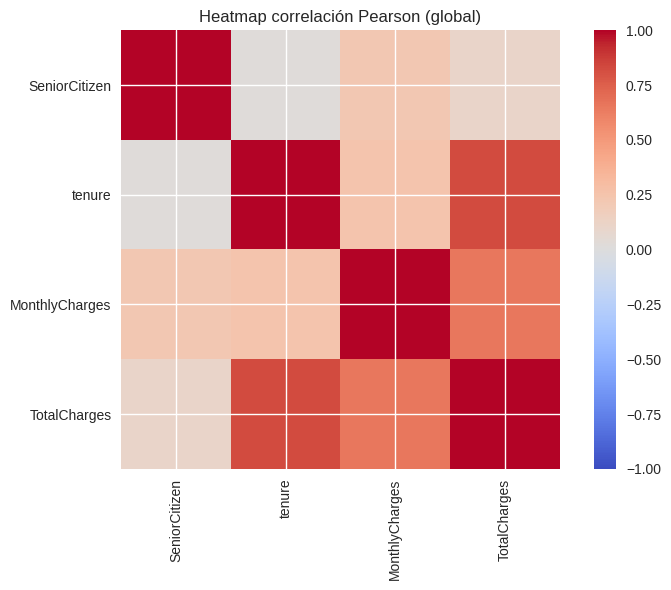

Clase=0 | pares |r|>=0.7: 2
  tenure                    TotalCharges              r= 0.793
  MonthlyCharges            TotalCharges              r= 0.757
Clase=1 | pares |r|>=0.7: 1
  tenure                    TotalCharges              r= 0.954

Top pares categóricos por Cramér's V (>=0.5):
  customerID                gender                    V= 1.000
  customerID                Partner                   V= 1.000
  customerID                Dependents                V= 1.000
  customerID                PhoneService              V= 1.000
  customerID                MultipleLines             V= 1.000
  customerID                InternetService           V= 1.000
  customerID                OnlineSecurity            V= 1.000
  customerID                OnlineBackup              V= 1.000
  customerID                DeviceProtection          V= 1.000
  customerID                TechSupport               V= 1.000
  customerID                StreamingTV               V= 1.000
  customerID   

In [24]:

# %% Diagnóstico de dependencia

# Correlaciones globales
pearson = X[num_cols].corr(method='pearson') if len(num_cols) else pd.DataFrame()
spearman = X[num_cols].corr(method='spearman') if len(num_cols) else pd.DataFrame()

if not pearson.empty:
    plt.figure(figsize=(8,6))
    plt.imshow(pearson, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(); plt.xticks(range(len(pearson)), pearson.columns, rotation=90); plt.yticks(range(len(pearson)), pearson.columns)
    plt.title('Heatmap correlación Pearson (global)'); plt.tight_layout(); plt.show()

# Correlaciones por clase (Pearson)
if len(num_cols) >= 2:
    for cls in np.unique(y):
        corr_c = X.loc[y==cls, num_cols].corr(method='pearson')
        top_pairs = []
        cols = corr_c.columns
        for i in range(len(cols)):
            for j in range(i+1, len(cols)):
                r = corr_c.iloc[i,j]
                if np.isfinite(r) and abs(r) >= 0.7:
                    top_pairs.append((cols[i], cols[j], r))
        print(f"Clase={cls} | pares |r|>=0.7: {len(top_pairs)}")
        for a,b,r in sorted(top_pairs, key=lambda t: abs(t[2]), reverse=True)[:10]:
            print(f"  {a:<25} {b:<25} r={r: .3f}")

# Cramér's V entre categóricas
if len(cat_cols) >= 2:
    def cramers_v_matrix(df_cat):
        cols = df_cat.columns
        V = pd.DataFrame(np.eye(len(cols)), index=cols, columns=cols)
        for i in range(len(cols)):
            for j in range(i+1, len(cols)):
                ct = pd.crosstab(df_cat[cols[i]].astype(str), df_cat[cols[j]].astype(str))
                v = association(ct.values, method='cramer', correction=False)
                V.loc[cols[i], cols[j]] = v
                V.loc[cols[j], cols[i]] = v
        return V
    V_mat = cramers_v_matrix(X[cat_cols])
    print("""
Top pares categóricos por Cramér's V (>=0.5):""")
    pairs = []
    for i in range(len(V_mat.columns)):
        for j in range(i+1, len(V_mat.columns)):
            v = V_mat.iloc[i,j]
            pairs.append((V_mat.index[i], V_mat.columns[j], v))
    for a,b,v in sorted(pairs, key=lambda t: t[2], reverse=True)[:20]:
        if v >= 0.5:
            print(f"  {a:<25} {b:<25} V={v: .3f}")

# VIF numéricas
if len(num_cols) >= 2:
    vifs = []
    df_num = X[num_cols]
    for col in df_num.columns:
        y_i = df_num[col].values
        X_i = df_num.drop(columns=[col]).values
        mask = np.isfinite(y_i) & np.isfinite(X_i).all(axis=1)
        y_i = y_i[mask]; X_i = X_i[mask]
        if len(y_i) < 5:
            vifs.append((col, np.nan))
            continue
        lr = LinearRegression().fit(X_i, y_i)
        r2 = lr.score(X_i, y_i)
        vif = np.inf if (1-r2) <= 1e-12 else 1.0/(1.0 - r2)
        vifs.append((col, vif))
    vif_tbl = pd.DataFrame(vifs, columns=['feature','VIF']).sort_values('VIF', ascending=False)
    print("""
Top VIF (numéricas):
""", vif_tbl.head(15).to_string(index=False))


## Paso 2. SVM
- **Lineal** (`SVC(kernel='linear')`): interpretabilidad vía **pesos \(w\)**, eficiencia en alto‑d.  
- **RBF** (`SVC(kernel='rbf')`): captura **no linealidad** mediante \(\gamma\) y **C**; mayor costo y menor interpretabilidad.  
- **Escalamiento** es crítico en SVM para que el margen/kernels funcionen correctamente.  
- **Selección de hiperparámetros**: `C` (ambos), `gamma` (RBF). Métrica principal: **F1 macro** (puedes cambiar a PR‑AUC si churn es minoritaria).


Fitting 2 folds for each of 3 candidates, totalling 6 fits
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Tiempo SVM lineal (búsqueda): 9.83 s | SVM RBF (búsqueda): 660.27 s
Mejor SVM lineal: {'clf__C': 10} | CV F1 macro: 0.7286
Mejor SVM RBF   : {'clf__C': np.float64(1.976218934028007), 'clf__gamma': np.float64(0.007476312062252299)} | CV F1 macro: 0.7161
Tiempo calibración: lineal=1.45 s | rbf=47.21 s

===== TEST REPORT [SVM lineal (calibrado)] =====
Accuracy:           0.8006
Precision (macro):  0.7468
Recall (macro):     0.7157
F1 (macro):         0.7279
AUC-ROC (macro OvR):0.8365
PR-AUC  (macro):    0.7795

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



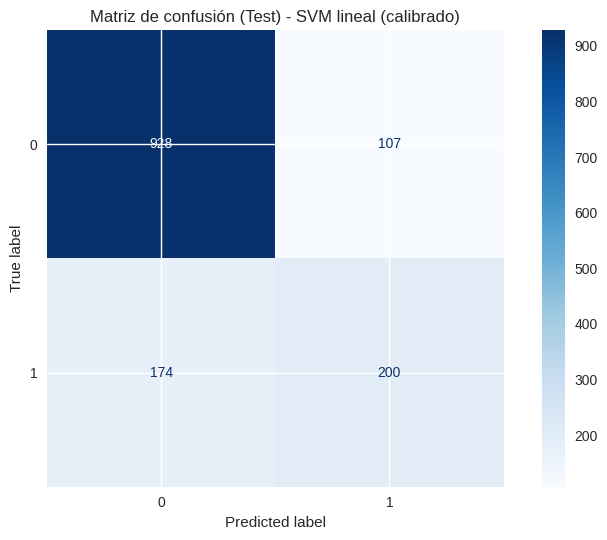


===== TEST REPORT [SVM RBF (calibrado)] =====
Accuracy:           0.7970
Precision (macro):  0.7447
Recall (macro):     0.6988
F1 (macro):         0.7147
AUC-ROC (macro OvR):0.8311
PR-AUC  (macro):    0.7766

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.49      0.56       374

    accuracy                           0.80      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.79      0.80      0.79      1409



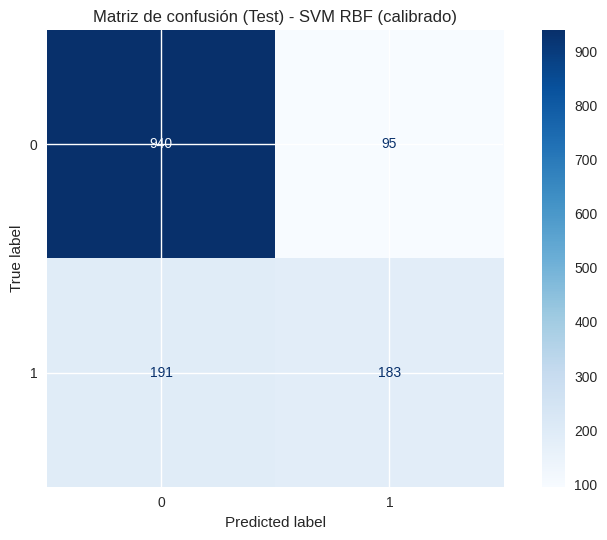


===== COMPARACIÓN (TEST) =====
     acc: lineal=0.8006 | rbf=0.7970 | Δ=-0.0035
    prec: lineal=0.7468 | rbf=0.7447 | Δ=-0.0021
     rec: lineal=0.7157 | rbf=0.6988 | Δ=-0.0169
      f1: lineal=0.7279 | rbf=0.7147 | Δ=-0.0133
 roc_auc: lineal=0.8365 | rbf=0.8311 | Δ=-0.0055
  pr_auc: lineal=0.7795 | rbf=0.7766 | Δ=-0.0029


In [25]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    roc_auc_score, average_precision_score, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve
)
from scipy.stats import loguniform

# ---------------------------
# 0) Opciones de rapidez
# ---------------------------
N_JOBS = -1
CV_FOLDS = 2              # menos folds para acelerar
CACHE_DIR = "./__cache__" # cachea transformaciones del pipeline
RANDOM_STATE = 42

# ---------------------------
# 1) Modelos base
# ---------------------------
# Lineal rápido con LinearSVC
svc_lin_fast = LinearSVC(random_state=RANDOM_STATE, max_iter=5000)
pipe_lin_fast = Pipeline([('prep', preproc_dense), ('clf', svc_lin_fast)], memory=CACHE_DIR)

# RBF rápido con SVC
svc_rbf_fast = SVC(kernel='rbf', probability=False, random_state=RANDOM_STATE)
pipe_rbf_fast = Pipeline([('prep', preproc_dense), ('clf', svc_rbf_fast)], memory=CACHE_DIR)

# ---------------------------
# 2) Grids / distribuciones
# ---------------------------
param_grid_lin = {'clf__C': [0.1, 1, 10]}
param_dist_rbf = {
    'clf__C': loguniform(1e-1, 1e2),
    'clf__gamma': loguniform(1e-3, 1e0)
}

SCORING_FAST = 'f1_macro'
cv_fast = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# ---------------------------
# 3) Búsqueda hiperparámetros
# ---------------------------
# Lineal
gs_lin = RandomizedSearchCV(pipe_lin_fast, param_grid_lin, n_iter=len(param_grid_lin['clf__C']),
                            scoring=SCORING_FAST, cv=cv_fast, n_jobs=N_JOBS, verbose=1,
                            random_state=RANDOM_STATE)

# RBF
rs_rbf = RandomizedSearchCV(pipe_rbf_fast, param_dist_rbf, n_iter=10,
                            scoring=SCORING_FAST, cv=cv_fast, n_jobs=N_JOBS, verbose=1,
                            random_state=RANDOM_STATE)

start = time.time()
gs_lin.fit(X_train, y_train)
mid = time.time()
rs_rbf.fit(X_train, y_train)
end = time.time()

print("Tiempo SVM lineal (búsqueda): {:.2f} s | SVM RBF (búsqueda): {:.2f} s".format(mid-start, end-mid))
print("Mejor SVM lineal:", gs_lin.best_params_, "| CV F1 macro:", "{:.4f}".format(gs_lin.best_score_))
print("Mejor SVM RBF   :", rs_rbf.best_params_, "| CV F1 macro:", "{:.4f}".format(rs_rbf.best_score_))

best_lin_fast = gs_lin.best_estimator_
best_rbf_fast = rs_rbf.best_estimator_

# ---------------------------
# 4) Calibración probabilidades (sigmoid más rápido)
# ---------------------------
cal_lin = CalibratedClassifierCV(best_lin_fast, method='sigmoid', cv=CV_FOLDS)
cal_rbf = CalibratedClassifierCV(best_rbf_fast, method='sigmoid', cv=CV_FOLDS)

start = time.time()
cal_lin.fit(X_train, y_train)
mid = time.time()
cal_rbf.fit(X_train, y_train)
end = time.time()
print("Tiempo calibración: lineal={:.2f} s | rbf={:.2f} s".format(mid-start, end-mid))

# ---------------------------
# 5) Evaluación en test
# ---------------------------
def eval_model(model, name):
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    acc            = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

    classes_unique = np.unique(y_train)
    roc_auc_per_class = []
    pr_auc_per_class = []
    for i in range(len(classes_unique)):
        y_true_binary_class = (y_test == classes_unique[i]).astype(int)
        y_proba_class = y_proba[:, i]
        roc_auc_per_class.append(roc_auc_score(y_true_binary_class, y_proba_class))
        pr_auc_per_class.append(average_precision_score(y_true_binary_class, y_proba_class))

    roc_auc = np.mean(roc_auc_per_class)
    pr_auc = np.mean(pr_auc_per_class)

    print(f"""
===== TEST REPORT [{name}] =====""")
    print(f"Accuracy:           {acc:.4f}")
    print(f"Precision (macro):  {prec:.4f}")
    print(f"Recall (macro):     {rec:.4f}")
    print(f"F1 (macro):         {f1:.4f}")
    print(f"AUC-ROC (macro OvR):{roc_auc:.4f}")
    print(f"PR-AUC  (macro):    {pr_auc:.4f}")
    print("""
Classification report:
""", classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
    plt.title(f"Matriz de confusión (Test) - {name}")
    plt.tight_layout()
    plt.show()

    return dict(acc=acc, prec=prec, rec=rec, f1=f1, roc_auc=roc_auc, pr_auc=pr_auc, proba=y_proba)

res_lin = eval_model(cal_lin, 'SVM lineal (calibrado)')
res_rbf = eval_model(cal_rbf, 'SVM RBF (calibrado)')

print("""
===== COMPARACIÓN (TEST) =====""")
for m in ['acc','prec','rec','f1','roc_auc','pr_auc']:
    print(f"{m:>8}: lineal={res_lin[m]:.4f} | rbf={res_rbf[m]:.4f} | Δ={res_rbf[m]-res_lin[m]:+.4f}")


## Paso 3. Análisis crítico
**Interpretabilidad:** SVM **lineal** permite análisis vía **\(w\)** (tras *one‑hot*), útil para explicar qué atributos empujan hacia churn. SVM **RBF** ofrece mejor capacidad en **no linealidad** pero menor interpretabilidad.  
**Escalamiento:** crítico para SVM; sin `StandardScaler`, los *features* con mayor escala dominan el margen/función kernel, deteriorando el desempeño.  
**Dimensionalidad (one‑hot):** incrementa el número de columnas; puede mejorar **separabilidad** pero aumenta **tiempo** de entrenamiento.  
**NB vs SVM:** NB es **rápido** y simple; puede rendir bien, pero la **dependencia** entre predictores viola su supuesto y afecta la calibración. SVM lineal es una buena **línea base interpretable**; RBF se recomienda si gana consistentemente en **F1/ROC/PR**.

> Para probabilidades mejor calibradas (cualquier clasificador), puede usarse `CalibratedClassifierCV` (métodos *sigmoid* o *isotonic*).